In [129]:
# Importing relevant libraries
import pandas as pd
from sklearn.decomposition import LatentDirichletAllocation, NMF
from sklearn.feature_extraction.text import TfidfVectorizer
import matplotlib.pyplot as plt
from nltk import WordNetLemmatizer
from nltk.corpus import stopwords
import re

# plt.style.use('ggplot')
plt.style.use('bmh')

In [130]:
# Loading the dataset into a pandas dataframe

research_articles = pd.read_csv('train.csv')
research_articles.head()

,ID,TITLE,ABSTRACT,Computer Science,Physics,Mathematics,Statistics,Quantitative Biology,Quantitative Finance
0,1,Reconstructing Subject-Specific Effect Maps,Predictive models allow subject-specific inf...,1,0,0,0,0,0
1,2,Rotation Invariance Neural Network,Rotation invariance and translation invarian...,1,0,0,0,0,0
2,3,Spherical polyharmonics and Poisson kernels fo...,We introduce and develop the notion of spher...,0,0,1,0,0,0
3,4,A finite element approximation for the stochas...,The stochastic Landau--Lifshitz--Gilbert (LL...,0,0,1,0,0,0
4,5,Comparative study of Discrete Wavelet Transfor...,Fourier-transform infra-red (FTIR) spectra o...,1,0,0,1,0,0


This dataset contains the ground truth topics for each of the article. Some of the articles are bothering more than one subject. This will make it somewhat difficult to infer topics based on suggested keywords. Mathematics and Physics have strong word connections for particular sub-areas. The same can also be said of Computer Science and Statistics. There is a lot of interdisciplinary dependencies between these topics.

In [131]:
research_articles.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20972 entries, 0 to 20971
Data columns (total 9 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   ID                    20972 non-null  int64 
 1   TITLE                 20972 non-null  object
 2   ABSTRACT              20972 non-null  object
 3   Computer Science      20972 non-null  int64 
 4   Physics               20972 non-null  int64 
 5   Mathematics           20972 non-null  int64 
 6   Statistics            20972 non-null  int64 
 7   Quantitative Biology  20972 non-null  int64 
 8   Quantitative Finance  20972 non-null  int64 
dtypes: int64(7), object(2)
memory usage: 1.4+ MB


In [132]:
research_articles.isnull().sum()

ID                      0
TITLE                   0
ABSTRACT                0
Computer Science        0
Physics                 0
Mathematics             0
Statistics              0
Quantitative Biology    0
Quantitative Finance    0
dtype: int64

In [133]:
research_articles.shape

(20972, 9)

# Text Preprocessing

In [134]:
# Printing out samples of the corpus

print(research_articles['ABSTRACT'][5])

  Let $\Omega \subset \mathbb{R}^n$ be a bounded domain satisfying a
Hayman-type asymmetry condition, and let $ D $ be an arbitrary bounded domain
referred to as "obstacle". We are interested in the behaviour of the first
Dirichlet eigenvalue $ \lambda_1(\Omega \setminus (x+D)) $. First, we prove an
upper bound on $ \lambda_1(\Omega \setminus (x+D)) $ in terms of the distance
of the set $ x+D $ to the set of maximum points $ x_0 $ of the first Dirichlet
ground state $ \phi_{\lambda_1} > 0 $ of $ \Omega $. In short, a direct
corollary is that if \begin{equation} \mu_\Omega := \max_{x}\lambda_1(\Omega
\setminus (x+D)) \end{equation} is large enough in terms of $ \lambda_1(\Omega)
$, then all maximizer sets $ x+D $ of $ \mu_\Omega $ are close to each maximum
point $ x_0 $ of $ \phi_{\lambda_1} $.
Second, we discuss the distribution of $ \phi_{\lambda_1(\Omega)} $ and the
possibility to inscribe wavelength balls at a given point in $ \Omega $.
Finally, we specify our observations to convex

This particular dataset was prepared using the $\LaTeX$ typesetting software, which contains some symbols and notations that will not be appropriate as input for the ML models. These symbols will be removed during the preprocessing steps.

In [135]:
# Loading lemmatizer and defining the preprocessing function to remove undesired notations
lm = WordNetLemmatizer()

def preprocess_text(text):
    """
        Function takes in the column of a dataframe, removes the inline equations, equation environments,
        tokenizes the texts applies lemmatization and removes stop words.

    Returns:
        The cleaned corpus
    """
    # removing inline equations
    corpus = re.sub(r'\$.*?\$|\$\s.*?\s\$', '', text)
    # removing equation environments
    corpus = re.sub(r'\\begin{equation}\s.*?\s\\end{equation}', '', corpus)
    # applying tokenization
    corpus = re.split('\W+', corpus)
    # applying lemmatization
    corpus = [lm.lemmatize(word) for word in corpus]
    corpus = " ".join(corpus)
    # set of stop words 
    stop_words = set(stopwords.words("english"))
    # removing the stop words 
    cleaned_corpus = [word for word in  
                              corpus.split()
                              if word.lower() not in stop_words]
    
    return ' '.join(cleaned_corpus)

In [136]:
# Defining a new dataframe to contain onlt the title and abstract of the original dataframe

new_dataframe = research_articles[['TITLE', 'ABSTRACT']]
new_dataframe.loc[:, 'ABSTRACT'] = research_articles['ABSTRACT'].apply(lambda x: preprocess_text(x))

In [137]:
# Viewing a sample of the preprocessed text for any unwanted notations
print(new_dataframe['ABSTRACT'][5])

Let bounded domain satisfying Hayman type asymmetry condition let arbitrary bounded domain referred obstacle interested behaviour first Dirichlet eigenvalue First prove upper bound term distance set set maximum point first Dirichlet ground state short direct corollary begin equation mu_ Omega max_ x lambda_1 Omega setminus x end equation large enough term maximizer set close maximum point Second discus distribution possibility inscribe wavelength ball given point Finally specify observation convex obstacle show sufficiently large respect maximizers contain maximum point


In [138]:
new_dataframe.shape

(20972, 2)

In [139]:
# Hardcoding the number of topics, and top words to be displayed

no_of_features = 5000
no_of_components = 6
top_n_words = 20

In [140]:
# Initializing the vectorizer instance

tfidf = TfidfVectorizer(max_df=0.95, 
                        min_df=3, 
                        max_features=no_of_features)

In [141]:
# Fiting and transforming the ABSTRACT column using the intialized vectorizer instance

dtm = tfidf.fit_transform(new_dataframe['ABSTRACT'])
dtm

<20972x5000 sparse matrix of type '<class 'numpy.float64'>'
	with 1259857 stored elements in Compressed Sparse Row format>

In [142]:
tfidf_features = tfidf.get_feature_names_out()
len(tfidf_features)

5000

# Model Training and Evaluation

In [143]:
# Initializing the Non-negative Matrix Factorization model instance

nmf_model = NMF(n_components=6,
                random_state=42,
                init='nndsvd')
nmf_model

NMF(init='nndsvd', n_components=6, random_state=42)

In [144]:
# Fitting the intialized model to the vectorized corpus
nmf_model.fit(dtm)

NMF(init='nndsvd', n_components=6, random_state=42)

In [145]:
# Defining two helper functions that were pulled out of the Scikit-Learn documentation for LDA model

def display_topics(model, feature_names, no_top_words):
    """
    Generates the number of top words specified in no_to_words
    for the specified model.
    """
    for topic_idx, topic in enumerate(model.components_):
        print("Topic %d:" %topic_idx)
        print(" ".join([feature_names[i]
                        for i in topic.argsort()[:-no_top_words - 1:-1]]), '\n')
        
def plot_top_words(model, feature_names, n_top_words, title):
    """
        Generates the visual representation of the number of top words
        specified in n_top_words for the model.
    """
    fig, axes = plt.subplots(2, 3, figsize=(30, 15), sharex=True)
    axes = axes.flatten()
    for topic_idx, topic in enumerate(model.components_):
        top_features_ind = topic.argsort()[-n_top_words:]
        top_features = feature_names[top_features_ind]
        weights = topic[top_features_ind]

        ax = axes[topic_idx]
        ax.barh(top_features, weights, height=0.7)
        ax.set_title(f"Topic {topic_idx +1}", fontdict={"fontsize": 30})
        ax.tick_params(axis="both", which="major", labelsize=20)
        for i in "top right left".split():
            ax.spines[i].set_visible(False)
        fig.suptitle(title, fontsize=40)

    plt.subplots_adjust(top=0.90, bottom=0.05, wspace=0.90, hspace=0.3)
    plt.tight_layout()
    plt.show()

In [146]:
display_topics(nmf_model, tfidf_features, top_n_words)

Topic 0:
algorithm problem method optimization optimal time solution stochastic gradient convergence convex proposed function control matrix bound learning based linear approach 

Topic 1:
group space equation algebra function prove operator finite theory result theorem solution manifold class give type condition set case polynomial 

Topic 2:
spin phase field magnetic system energy state temperature quantum transition electron effect interaction wave density mass particle two star material 

Topic 3:
network learning neural deep task image training feature architecture classification method performance representation approach based machine convolutional system art end 

Topic 4:
graph vertex edge node network random number algorithm degree structure tree set problem path time community property directed walk connected 

Topic 5:
model data distribution method estimator parameter process sample approach inference analysis based estimation variable bayesian test regression proposed esti

In [147]:
# import numpy as np

# # Defining function that will show the top n keywords for each topic as a dataframe
# def show_topics(vectorizer=tfidf, lda_model=nmf_model, n_words=top_n_words):
#     keywords = np.array(vectorizer.get_feature_names_out())
#     topic_keywords = []
#     for topic_weights in lda_model.components_:
#         top_keyword_locs = (-topic_weights).argsort()[:n_words]
#         topic_keywords.append(keywords.take(top_keyword_locs))
#     return topic_keywords

# topic_keywords = show_topics(vectorizer=tfidf, lda_model=nmf_model, n_words=top_n_words) 

# # Topic - Keywords Dataframe
# df_topic_keywords = pd.DataFrame(topic_keywords)
# df_topic_keywords.columns = ['Word '+str(i) for i in range(df_topic_keywords.shape[1])]
# df_topic_keywords.index = ['Topic '+str(i) for i in range(df_topic_keywords.shape[0])]
# df_topic_keywords

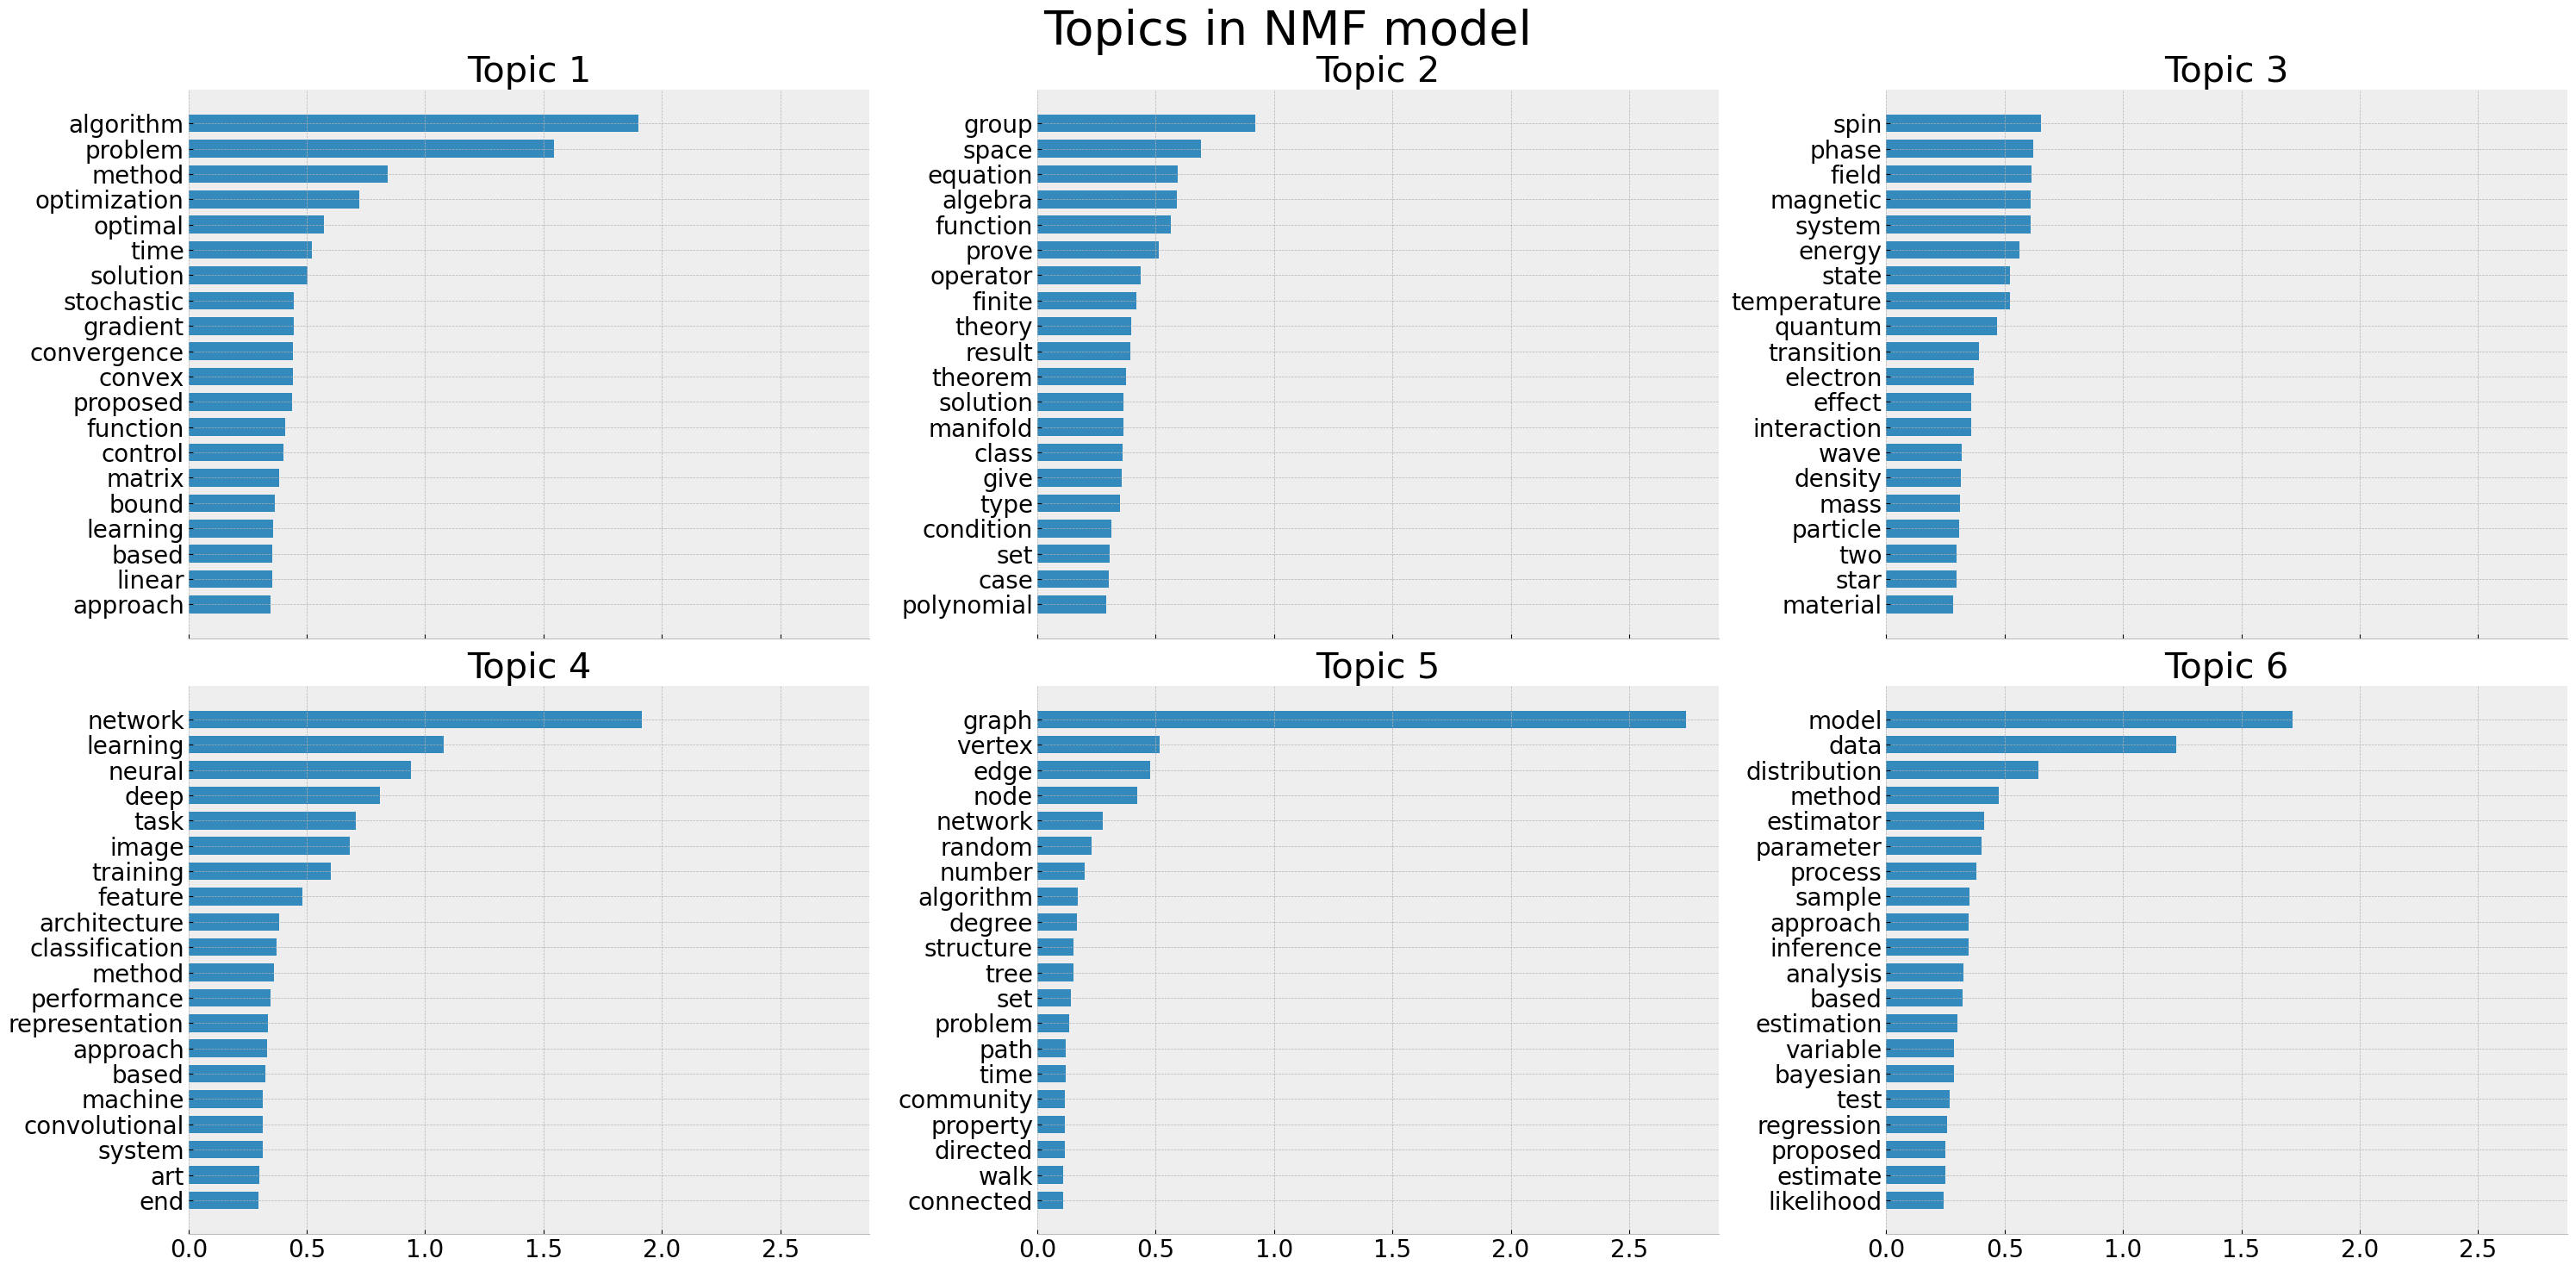

In [148]:
# Visualizing the top words and their frequency
plot_top_words(nmf_model, tfidf_features, top_n_words, 'Topics in NMF model')

In [149]:
# Manually creating the dictionary of topics inferred from the sumaary keywords provided by the NMF model 

topic_dict_nmf = {0: 'Quantitative Finance', 
              1: 'Mathematics', 
              2: 'Physics', 
              3: 'Computer Science', 
              4: 'Quantitative Biology', 
              5: 'Statistics'}

In [150]:
# Using the fitted NMF model to transform the vectorized corpus

topic_results_nmf = nmf_model.transform(dtm)
topic_results_nmf

array([[3.55433408e-03, 0.00000000e+00, 4.56070957e-03, 1.53516183e-02,
        0.00000000e+00, 8.62871680e-02],
       [0.00000000e+00, 5.47792360e-03, 0.00000000e+00, 6.12141005e-02,
        0.00000000e+00, 0.00000000e+00],
       [2.27216287e-03, 4.14192878e-02, 0.00000000e+00, 2.46107409e-06,
        0.00000000e+00, 3.93069347e-03],
       ...,
       [0.00000000e+00, 1.07012655e-02, 8.15607396e-03, 5.24814856e-02,
        5.08840944e-05, 1.26120544e-02],
       [2.58683905e-02, 5.79742272e-03, 4.78292355e-04, 0.00000000e+00,
        1.94260361e-04, 4.99722954e-02],
       [1.33023277e-02, 4.82595704e-03, 0.00000000e+00, 0.00000000e+00,
        1.26512718e-03, 2.05639268e-02]])

In [185]:
# Creating a new column in the new_dataframe that will be the inferred topics from the model's suggested keywords

new_dataframe.loc[:,'TOPICS_NMF'] = topic_results_nmf.argmax(axis=1)
new_dataframe.loc[:,'TOPICS_NMF'] = new_dataframe['TOPICS_NMF'].map(topic_dict_nmf)

new_dataframe.head(10)

,TITLE,ABSTRACT,TOPICS_NMF,TOPICS_LDA
0,Reconstructing Subject-Specific Effect Maps,Predictive model allow subject specific infere...,Statistics,Computer Science
1,Rotation Invariance Neural Network,Rotation invariance translation invariance gre...,Computer Science,Computer Science
2,Spherical polyharmonics and Poisson kernels fo...,introduce develop notion spherical polyharmoni...,Mathematics,Mathematics
3,A finite element approximation for the stochas...,stochastic Landau Lifshitz Gilbert LLG equatio...,Mathematics,Statistics
4,Comparative study of Discrete Wavelet Transfor...,Fourier transform infra red FTIR spectrum samp...,Statistics,Computer Science
5,On maximizing the fundamental frequency of the...,Let bounded domain satisfying Hayman type asym...,Mathematics,Mathematics
6,On the rotation period and shape of the hyperb...,observed newly discovered hyperbolic minor pla...,Physics,Physics
7,Adverse effects of polymer coating on heat tra...,ability metallic nanoparticles supply heat liq...,Physics,Physics
8,SPH calculations of Mars-scale collisions: the...,model large scale 2000km impact Mars like plan...,Physics,Physics
9,$\mathcal{R}_{0}$ fails to predict the outbrea...,Time varying susceptibility host individual le...,Statistics,Quantitative Biology


In [171]:
# Initializing the LDA model instance

LDA = LatentDirichletAllocation(n_components=6,              
                                max_iter=10,               
                                learning_method='batch',       
                                batch_size=128,          
                                evaluate_every=-1,      
                                n_jobs=-1, 
                                random_state=42)
LDA.fit(dtm)

LatentDirichletAllocation(n_components=6, n_jobs=-1, random_state=42)

In [172]:
# Calculating the Log Likelihood of the LDA model: The higher the score, the better the model's suggestions
print("Log Likelihood:", LDA.score(dtm))

# Calculating the Perplexity: The lower the score, the better. Perplexity = exp(-1. * log-likelihood per word)
print("Perplexity:", LDA.perplexity(dtm))

Log Likelihood: -1105577.2729039246
Perplexity: 4576.473453273987


In [173]:
display_topics(LDA, tfidf_features, top_n_words)

Topic 0:
logic graph automaton language game tree program problem player semantics proof boolean calculus arm complexity vertex word formula set system 

Topic 1:
network model learning data method neural image approach task based deep algorithm training system performance feature proposed using problem time 

Topic 2:
field energy phase spin magnetic temperature state system model quantum wave effect particle mass electron star two transition density galaxy 

Topic 3:
network data user social system model paper information analysis research software based game community study different ha market time process 

Topic 4:
algorithm problem method model distribution matrix function estimator data bound stochastic graph random time parameter optimal convergence sample estimation linear 

Topic 5:
group equation space algebra function prove solution operator result manifold theory theorem finite give set paper type polynomial show class 



In [174]:
# # Creating a dataframe of the keywords for each topic

# topic_keywords = show_topics(vectorizer=tfidf, lda_model=LDA, n_words=top_n_words) 

# # Topic - Keywords Dataframe
# df_topic_keywords = pd.DataFrame(topic_keywords)
# df_topic_keywords.columns = ['Word '+str(i) for i in range(df_topic_keywords.shape[1])]
# df_topic_keywords.index = ['Topic '+str(i) for i in range(df_topic_keywords.shape[0])]
# df_topic_keywords

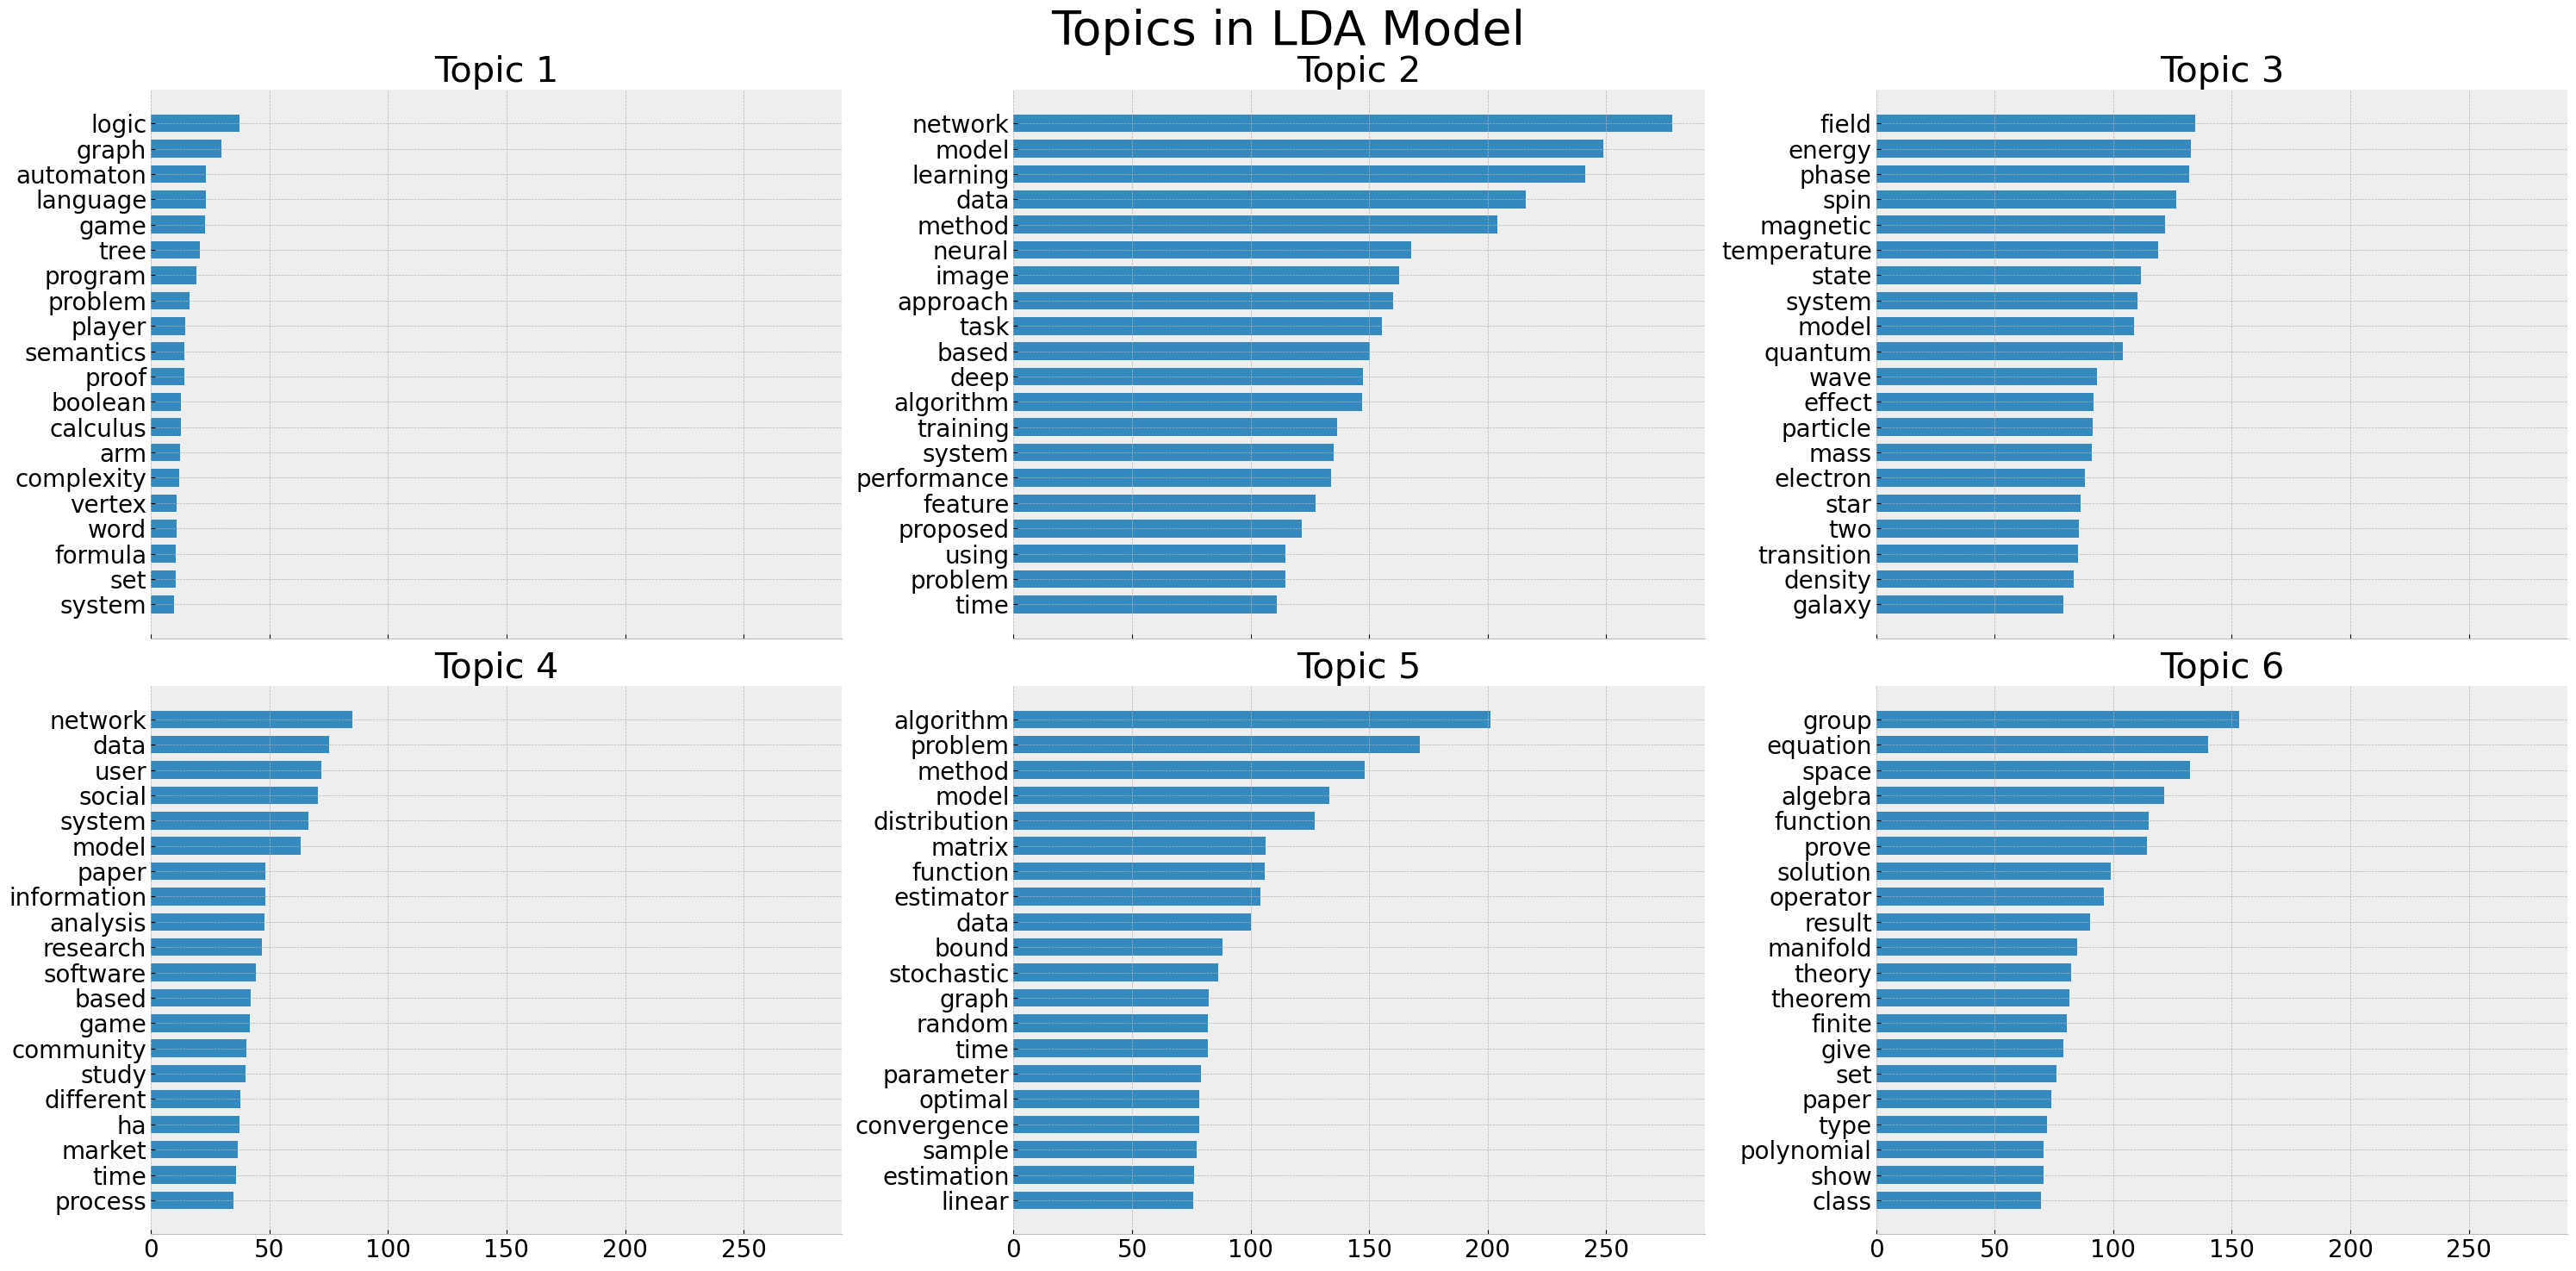

In [175]:
# Visualizing the top words and their frequency
plot_top_words(LDA, tfidf_features, top_n_words, 'Topics in LDA Model')

In [176]:
# Manually creating the dictionary of topics inferred from the sumaary keywords provided by the NMF model 

topic_dict_lda = {0: 'Quantitative Finance', 
              1: 'Computer Science', 
              2: 'Physics', 
              3: 'Quantitative Biology', 
              4: 'Statistics', 
              5: 'Mathematics'}

In [177]:
# Using the fitted LDA model to transform the vectorized corpus

topic_results_lda = LDA.transform(dtm)
topic_results_lda

array([[0.01731448, 0.91174008, 0.01851846, 0.017452  , 0.01754604,
        0.01742894],
       [0.02892619, 0.85900726, 0.02778294, 0.0276118 , 0.02772637,
        0.02894545],
       [0.03394312, 0.03392973, 0.03390466, 0.0338844 , 0.03416565,
        0.83017244],
       ...,
       [0.0220828 , 0.88939605, 0.02207556, 0.02219378, 0.02210357,
        0.02214824],
       [0.01952618, 0.01986375, 0.02138813, 0.01972164, 0.8998627 ,
        0.01963761],
       [0.02636409, 0.0265668 , 0.0264558 , 0.12908246, 0.7649736 ,
        0.02655726]])

In [178]:
# Creating a column in new_dataframe that contains the inferred topics using the model's suggested keywords

new_dataframe.loc[:,'TOPICS_LDA'] = topic_results_lda.argmax(axis=1)
new_dataframe.loc[:,'TOPICS_LDA'] = new_dataframe['TOPICS_LDA'].map(topic_dict_lda)

new_dataframe.head(20)

,TITLE,ABSTRACT,TOPICS_NMF,TOPICS_LDA
0,Reconstructing Subject-Specific Effect Maps,Predictive model allow subject specific infere...,Statistics,Computer Science
1,Rotation Invariance Neural Network,Rotation invariance translation invariance gre...,Computer Science,Computer Science
2,Spherical polyharmonics and Poisson kernels fo...,introduce develop notion spherical polyharmoni...,Mathematics,Mathematics
3,A finite element approximation for the stochas...,stochastic Landau Lifshitz Gilbert LLG equatio...,Mathematics,Statistics
4,Comparative study of Discrete Wavelet Transfor...,Fourier transform infra red FTIR spectrum samp...,Statistics,Computer Science
5,On maximizing the fundamental frequency of the...,Let bounded domain satisfying Hayman type asym...,Mathematics,Mathematics
6,On the rotation period and shape of the hyperb...,observed newly discovered hyperbolic minor pla...,Physics,Physics
7,Adverse effects of polymer coating on heat tra...,ability metallic nanoparticles supply heat liq...,Physics,Physics
8,SPH calculations of Mars-scale collisions: the...,model large scale 2000km impact Mars like plan...,Physics,Physics
9,$\mathcal{R}_{0}$ fails to predict the outbrea...,Time varying susceptibility host individual le...,Statistics,Quantitative Biology


In [160]:
# Manually comparing the predictions from the two models with the ground truth
research_articles.head(20)

,ID,TITLE,ABSTRACT,Computer Science,Physics,Mathematics,Statistics,Quantitative Biology,Quantitative Finance
0,1,Reconstructing Subject-Specific Effect Maps,Predictive models allow subject-specific inf...,1,0,0,0,0,0
1,2,Rotation Invariance Neural Network,Rotation invariance and translation invarian...,1,0,0,0,0,0
2,3,Spherical polyharmonics and Poisson kernels fo...,We introduce and develop the notion of spher...,0,0,1,0,0,0
3,4,A finite element approximation for the stochas...,The stochastic Landau--Lifshitz--Gilbert (LL...,0,0,1,0,0,0
4,5,Comparative study of Discrete Wavelet Transfor...,Fourier-transform infra-red (FTIR) spectra o...,1,0,0,1,0,0
5,6,On maximizing the fundamental frequency of the...,Let $\Omega \subset \mathbb{R}^n$ be a bound...,0,0,1,0,0,0
6,7,On the rotation period and shape of the hyperb...,We observed the newly discovered hyperbolic ...,0,1,0,0,0,0
7,8,Adverse effects of polymer coating on heat tra...,The ability of metallic nanoparticles to sup...,0,1,0,0,0,0
8,9,SPH calculations of Mars-scale collisions: the...,We model large-scale ($\approx$2000km) impac...,0,1,0,0,0,0
9,10,$\mathcal{R}_{0}$ fails to predict the outbrea...,Time varying susceptibility of host at indiv...,0,0,0,0,1,0


# Model Testing

In [161]:
# Loading the test dataset into dataframe

test_data = pd.read_csv('test.csv')
test_data.head()

,ID,TITLE,ABSTRACT
0,20973,Closed-form Marginal Likelihood in Gamma-Poiss...,We present novel understandings of the Gamma...
1,20974,Laboratory mid-IR spectra of equilibrated and ...,Meteorites contain minerals from Solar Syste...
2,20975,Case For Static AMSDU Aggregation in WLANs,Frame aggregation is a mechanism by which mu...
3,20976,The $Gaia$-ESO Survey: the inner disk intermed...,Milky Way open clusters are very diverse in ...
4,20977,Witness-Functions versus Interpretation-Functi...,Proving that a cryptographic protocol is cor...


In [162]:
test_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8989 entries, 0 to 8988
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   ID        8989 non-null   int64 
 1   TITLE     8989 non-null   object
 2   ABSTRACT  8989 non-null   object
dtypes: int64(1), object(2)
memory usage: 210.8+ KB


In [163]:
test_data.isnull().sum()

ID          0
TITLE       0
ABSTRACT    0
dtype: int64

In [164]:
test_data.shape

(8989, 3)

In [165]:
# Preprocessing the text and also transforming the text corpus into vectorized inputs for the NMF and LDA model

dtm_test = tfidf.transform(test_data['ABSTRACT'].apply(lambda x: preprocess_text(x)))
topic_results_nmf_test = nmf_model.transform(dtm_test)
topic_results_lda_test = LDA.transform(dtm_test)

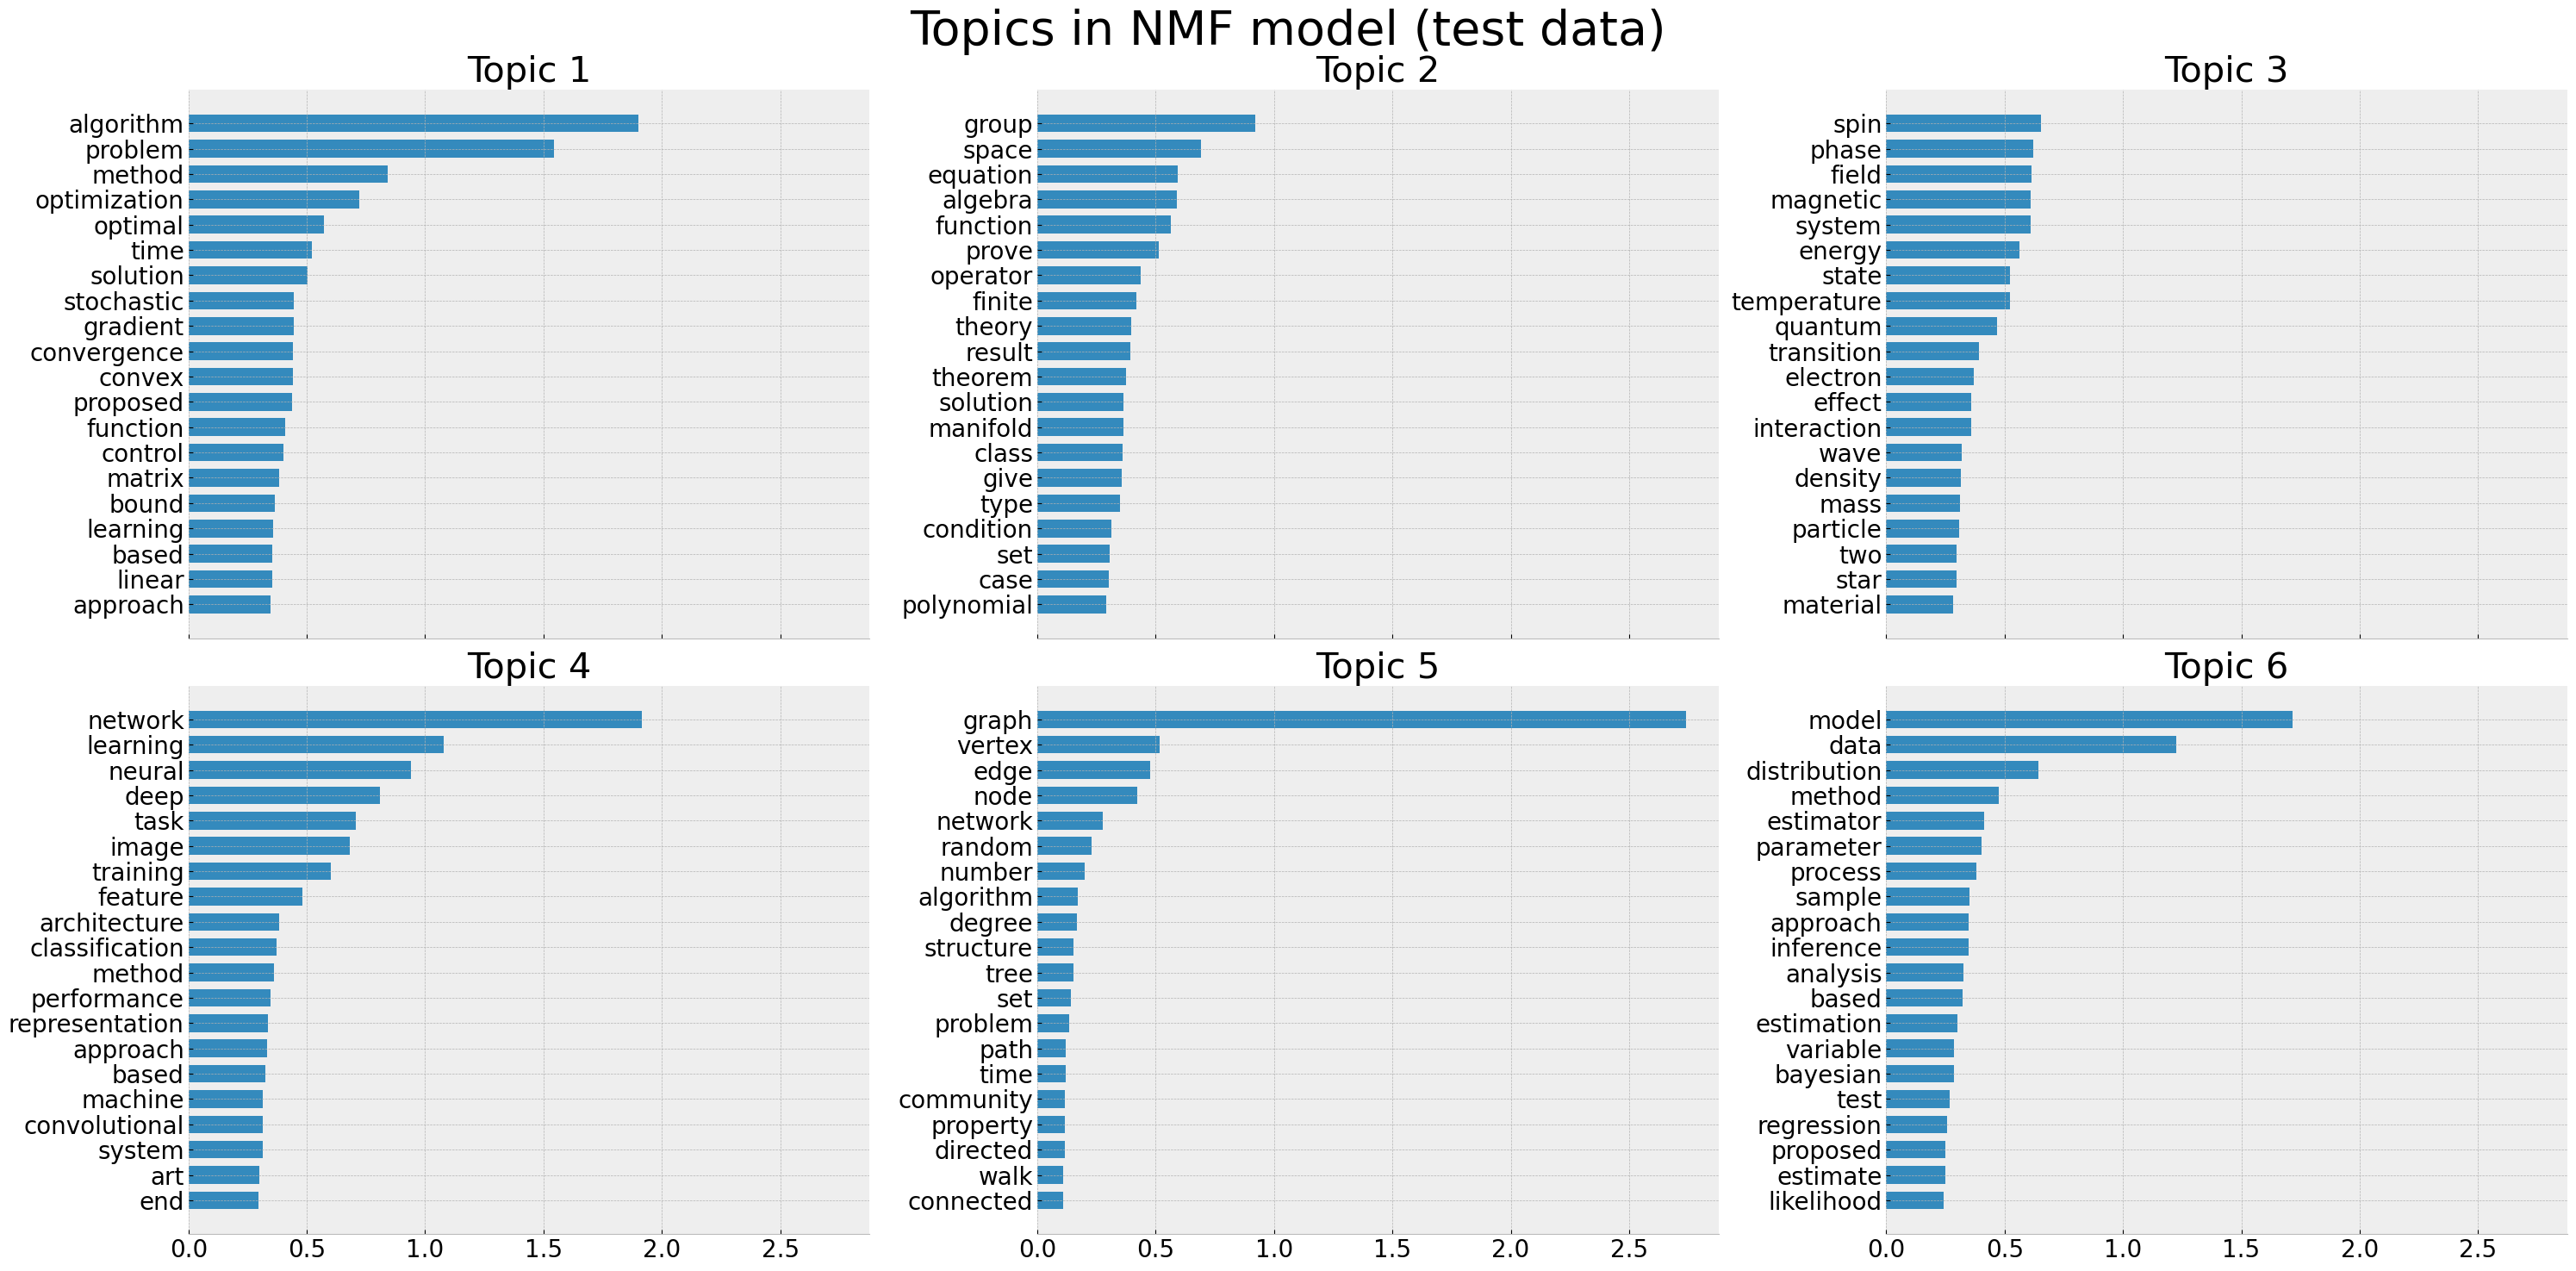

In [166]:
plot_top_words(nmf_model, tfidf_features, top_n_words, 'Topics in NMF model (test data)')

In [180]:
# Manually mapping the model's suggested keywords into ground truth topics

test_dict_nmf = {0: 'Quantitative Finance', 
              1: 'Mathematics', 
              2: 'Physics', 
              3: 'Computer Science', 
              4: 'Quantitative Biology', 
              5: 'Statistics'}

test_dataframe = test_data[['ABSTRACT']]

In [182]:
test_dataframe.loc[:,'TOPICS_NMF'] = topic_results_nmf_test.argmax(axis=1)
test_dataframe.loc[:,'TOPICS_NMF'] = test_dataframe['TOPICS_NMF'].map(test_dict_nmf)

test_dataframe.head(10)

,ABSTRACT,TOPICS_NMF
0,We present novel understandings of the Gamma...,Statistics
1,Meteorites contain minerals from Solar Syste...,Physics
2,Frame aggregation is a mechanism by which mu...,Statistics
3,Milky Way open clusters are very diverse in ...,Physics
4,Proving that a cryptographic protocol is cor...,Mathematics
5,This paper proposes a regularized pairwise d...,Statistics
6,A central issue in the theory of extreme val...,Statistics
7,Astrophysics and cosmology are rich with dat...,Statistics
8,A number of recent works have proposed techn...,Computer Science
9,We use the hydrodynamical galaxy formation s...,Physics


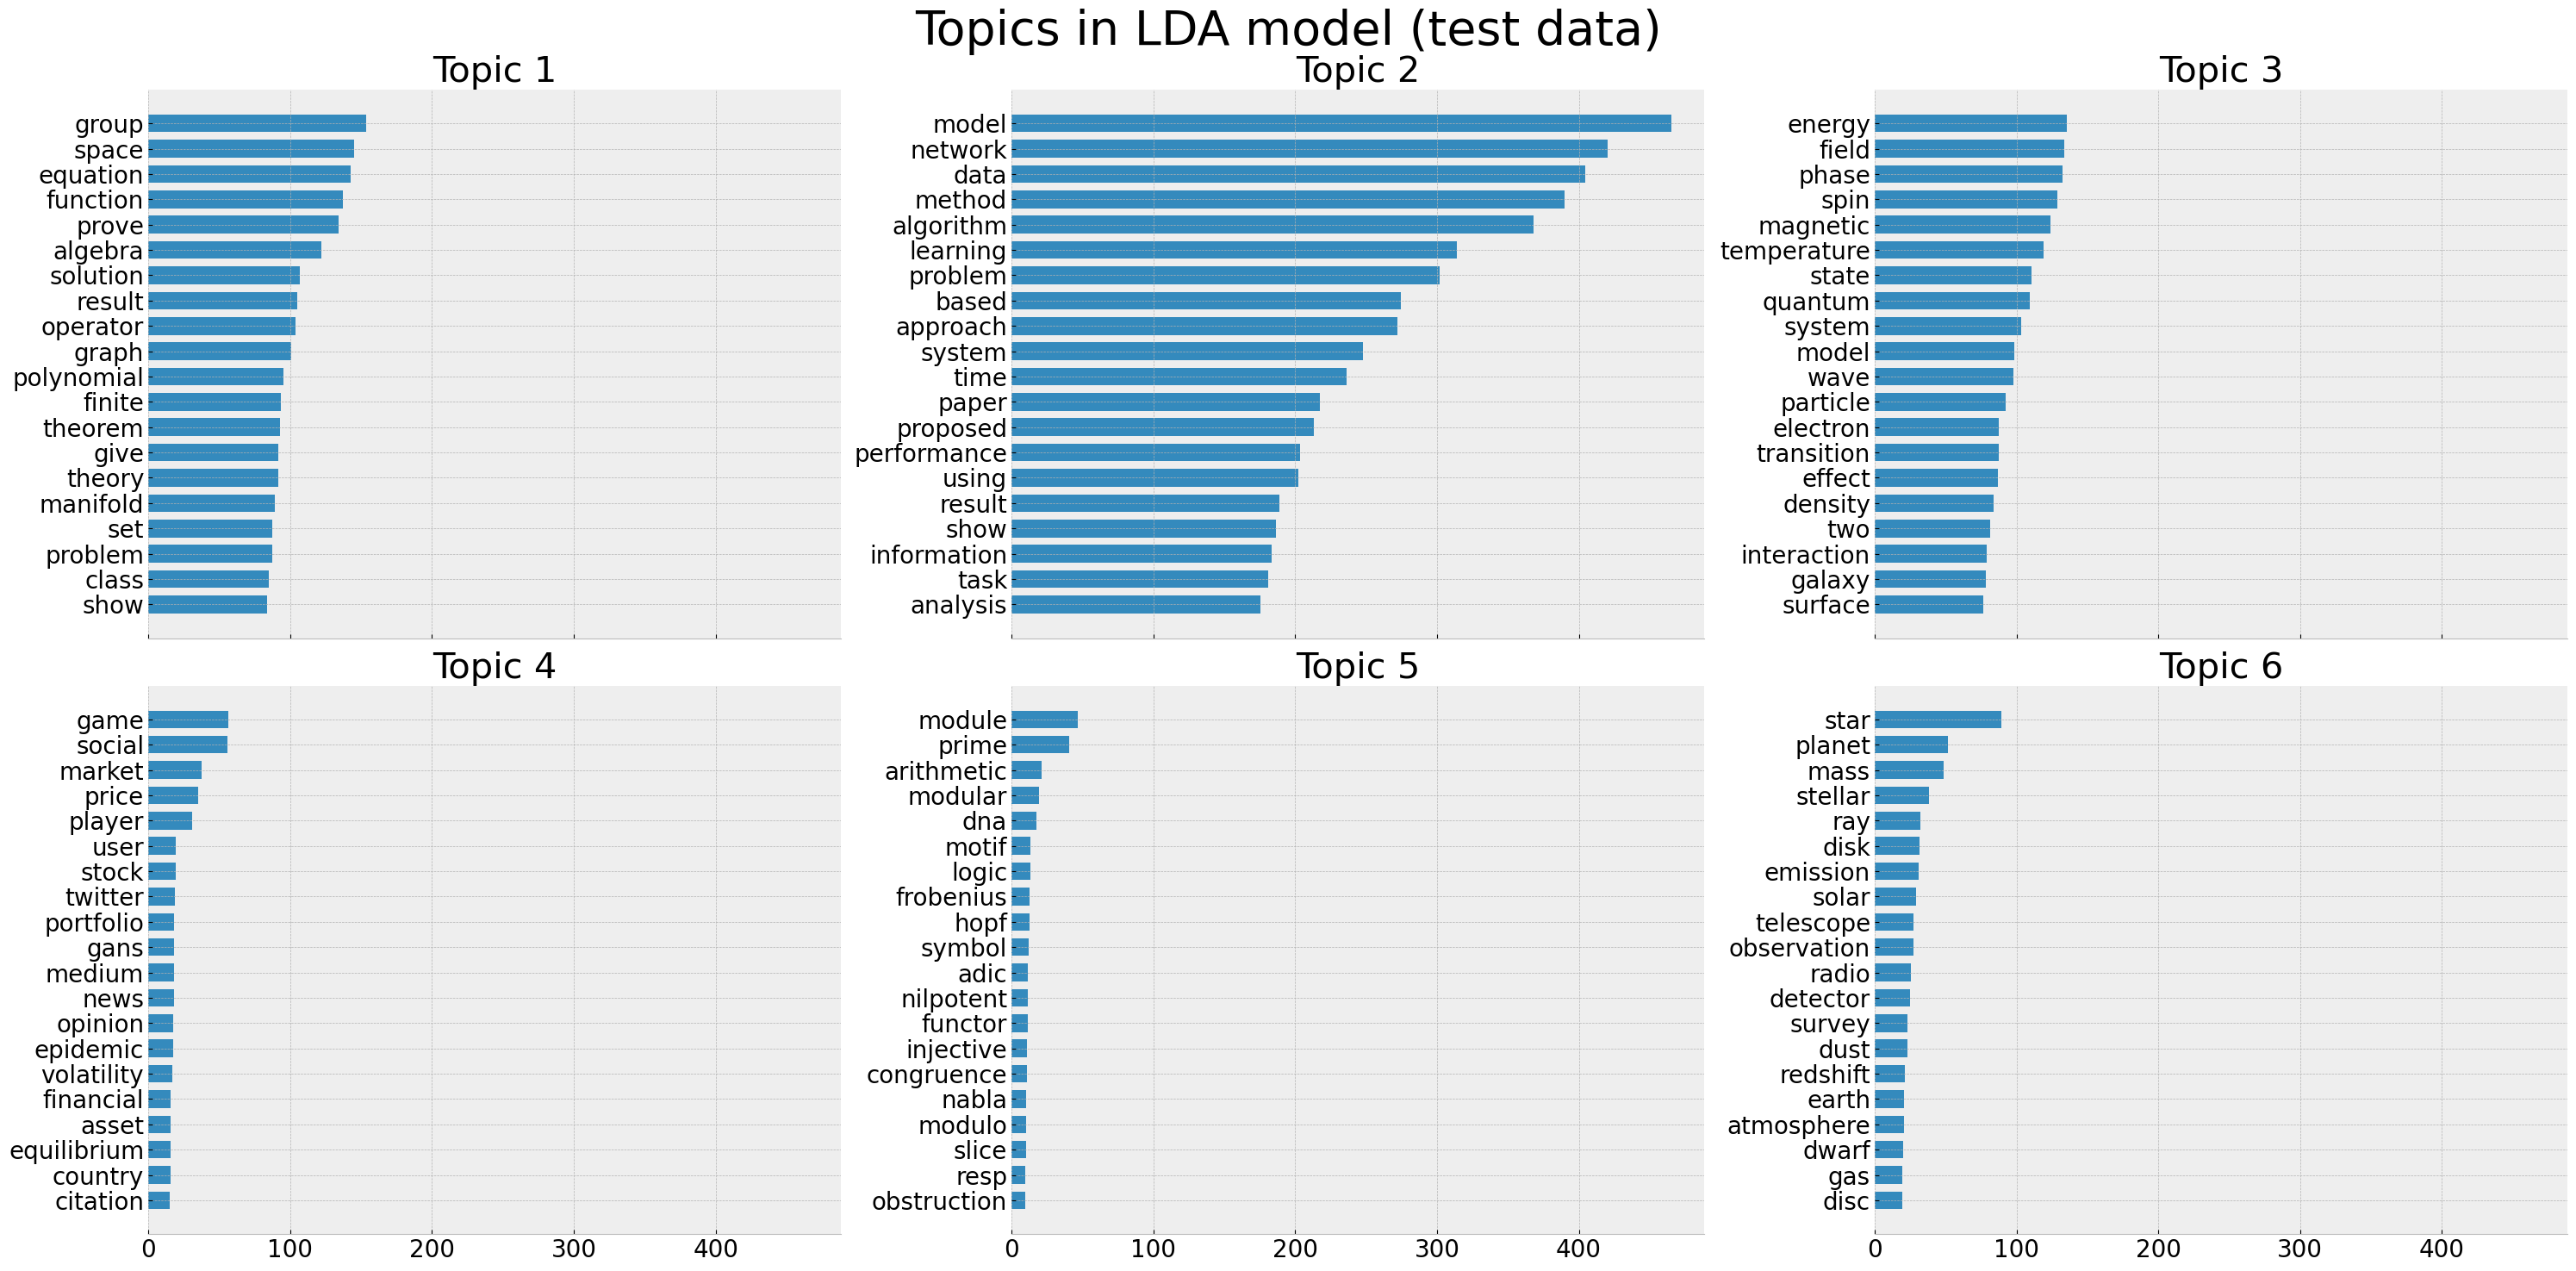

In [170]:
plot_top_words(LDA, tfidf_features, top_n_words, 'Topics in LDA model (test data)')

In [ ]:
# Manually mapping the model's suggested keywords into ground truth topics

test_dict_lda = {0: 'Mathematics', 
              1: 'Computer Science', 
              2: 'Physics', 
              3: 'Quantitative Finance', 
              4: 'Quantitative Biology', 
              5: 'Physics'}

In [183]:
test_dataframe.loc[:,'TOPICS_LDA'] = topic_results_lda_test.argmax(axis=1)
test_dataframe.loc[:,'TOPICS_LDA'] = test_dataframe['TOPICS_LDA'].map(test_dict_lda)

test_dataframe.head(10)

,ABSTRACT,TOPICS_NMF,TOPICS_LDA
0,We present novel understandings of the Gamma...,Statistics,Mathematics
1,Meteorites contain minerals from Solar Syste...,Physics,Physics
2,Frame aggregation is a mechanism by which mu...,Statistics,Mathematics
3,Milky Way open clusters are very diverse in ...,Physics,Physics
4,Proving that a cryptographic protocol is cor...,Mathematics,Mathematics
5,This paper proposes a regularized pairwise d...,Statistics,Mathematics
6,A central issue in the theory of extreme val...,Statistics,Mathematics
7,Astrophysics and cosmology are rich with dat...,Statistics,Mathematics
8,A number of recent works have proposed techn...,Computer Science,Mathematics
9,We use the hydrodynamical galaxy formation s...,Physics,Physics


In [184]:
print(test_data.ABSTRACT[6])

  A central issue in the theory of extreme values focuses on suitable
conditions such that the well-known results for the limiting distributions of
the maximum of i.i.d. sequences can be applied to stationary ones. In this
context, the extremal index appears as a key parameter to capture the effect of
temporal dependence on the limiting distribution of the maxima. The
multivariate extremal index corresponds to a generalization of this concept to
a multivariate context and affects the tail dependence structure within the
marginal sequences and between them. As it is a function, the inference becomes
more difficult, and it is therefore important to obtain characterizations,
namely bounds based on the marginal dependence that are easier to estimate. In
this work we present two decompositions that emphasize different types of
information contained in the multivariate extremal index, an upper limit better
than those found in the literature and we analyze its role in dependence on the
limiti

The suggested keywords from the LDA model is too cryptic for me to understand. The distinction between the keywords is really poor. For some of the suggested keywords, it is very difficult to map them to one of the ground truth topics.

# Conclusions from the experiments

In a concise summary, the suggested keywords from the Non-negative Matrix Factorization (NMF) were quite explicit and could be easily mapped to the ground truth topics for the training data. It was more difficult to assign the suggested keywords to ground truth topics for the test data. The suggested keywords from the Latent Dirichlet Allocation (LDA) model were intertwined and more difficult to decode for the training data. For the test data, the suggested keywords was unclear and had no meaning for five out of six topics.

After many different experimentations with different parameters, the NMF model consistently gave better suggested keywords compared to the LDA model. Despite the obvious advantage of the NMF model, it appears that the LDA model actually captures the realistic essence of the dataset as compared to the NMF model. Going by the first statement I made after loading the dataframe, there are a lot of interdisciplinary dependencies between the ground truth topics. For example, some areas of research in Mathematics and Physics can come under the same topic (nonlinear dynamics for example or nonlinear waves, differential equations to mention a few). There are also some areas of research between Computer Science and Statistics, or Physics and Computer Science or Mathematics and Computer Science that would have the same topic(s).

In the next notebook, I will be digging further into this dataset using the LDA model in the Gensim library.